## Import

In [21]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [22]:
%reload_ext autoreload
%autoreload 2
from soccer_xg.api import DataApi
import soccer_xg.xg as xg
from soccer_xg.utils import sample_temporal

## Config

In [23]:
# dataset
dir_data = "../data"
provider = 'wyscout_opensource'
leagues = ['ENG', 'ESP', 'ITA', 'GER', 'FRA']
seasons = ['1718']

# features
store_features = f'../data/{provider}/features.h5'

## Pre processing

### Load Data

In [24]:
api = DataApi([f"{dir_data}/{provider}/spadl-{provider}-{l}-{s}.h5" 
        for (l,s) in itertools.product(leagues, seasons)])

INFO:soccer_xg.api:Loading datasets


### Load Features

In [25]:
features = []
labels = []
# load features and labels for each season
for (l,s) in itertools.product(leagues, seasons):
    try:
        features.append(pd.read_hdf(store_features, key=f'{l}/{s}/features'))
        labels.append(pd.read_hdf(store_features, key=f'{l}/{s}/labels'))
    except KeyError:
        print(f"Key not found for league {l} and season {s}")
features = pd.concat(features)
labels = pd.concat(labels)
# filter open play shots
open_play_idx = features[features.type_id_a0 == 'shot'].index
features = features.loc[open_play_idx]
labels = labels.loc[open_play_idx]

display(features.head())
display(labels.to_frame().head())

type_id_a0      type_id_a1 type_id_a2 bodypart_id_a0  \
game_id action_id                                                        
2500098 17              shot         dribble      cross           foot   
        40              shot  corner_crossed       pass           foot   
        77              shot       clearance      cross           foot   
        140             shot           cross    dribble           foot   
        145             shot            pass       pass           foot   

                  bodypart_id_a1 bodypart_id_a2 result_id_a1 result_id_a2  \
game_id action_id                                                           
2500098 17                  foot           foot      success      success   
        40                  foot           foot      success         fail   
        77                  foot           foot         fail         fail   
        140                 foot           foot      success      success   
        145                 foot           foot      success      success   

                   start_x_a0  start_y_a0  ...  speed_a02  shot_angle_a0  \
game_id action_id                          ...                             
2500098 17              99.75       26.52  ...   1.319750       0.499778   
        40              91.35       35.36  ...   4.249364       0.517985   
        77              75.60       29.92  ...   5.874066       0.242481   
        140             92.40       43.52  ...   2.061543       0.371538   
        145             99.75       37.40  ...   1.289870       0.978291   

                   shot_angle_a1  shot_angle_a2  caley_zone_a0  caley_zone_a1  \
game_id action_id                                                               
2500098 17              0.483780       0.065500              2              3   
        40              0.000000       0.363334              3              8   
        77              0.491555       0.043863              6              3   
        140             0.134860       0.167545              4              5   
        145             0.654611       0.320841              1              3   

                   caley_zone_a2  angle_zone_a0  angle_zone_a1  angle_zone_a2  
game_id action_id                                                              
2500098 17                     8              9             12             18  
        40                     4             12             21             12  
        77                     0             18             12             18  
        140                    0             12             15             18  
        145                    4              6              9             15  

[5 rows x 59 columns]

goal
game_id action_id       
2500098 17         False
        40         False
        77         False
        140        False
        145        False

### Split train and test 

In [26]:
games_train, games_val, games_test = sample_temporal(api, size_val=0.2, size_test=0.3)

X_train, y_train = features.loc[games_train], labels.loc[games_train]
data_train = X_train.assign(goal=y_train)
X_val, y_val = features.loc[games_val], labels.loc[games_val]
data_val = X_train.assign(goal=y_val)
X_test, y_test = features.loc[games_test], labels.loc[games_test]
data_test = X_test.assign(goal=y_test)

INFO:soccer_xg.api:Loading `games` data


In [27]:
for name, X in [("train", X_train), ("val", X_val), ("test", X_test)]:
    print("dataset =", name)
    print("shape =", X.shape)
    print("-" * 20)

dataset = train
shape = (20652, 59)
--------------------
dataset = val
shape = (7781, 59)
--------------------
dataset = test
shape = (11965, 59)
--------------------


## Learning 

### Feature selection

In [28]:
# Get all numerical features
NUM = features.select_dtypes(include=['float64']).columns.tolist()

# Get all categorical features
CAT = features.select_dtypes(include=['object', 'category']).columns.tolist()

# Now you have arrays of all numerical and categorical features
print("Numerical features:", NUM)
print("Categorical features:", CAT)

Numerical features: ['start_x_a0', 'start_y_a0', 'start_x_a1', 'start_y_a1', 'start_x_a2', 'start_y_a2', 'end_x_a1', 'end_y_a1', 'end_x_a2', 'end_y_a2', 'dx_a1', 'dy_a1', 'movement_a1', 'dx_a2', 'dy_a2', 'movement_a2', 'dx_a01', 'dy_a01', 'mov_a01', 'dx_a02', 'dy_a02', 'mov_a02', 'start_dist_to_goal_a0', 'start_angle_to_goal_a0', 'start_dist_to_goal_a1', 'start_angle_to_goal_a1', 'start_dist_to_goal_a2', 'start_angle_to_goal_a2', 'end_dist_to_goal_a1', 'end_angle_to_goal_a1', 'end_dist_to_goal_a2', 'end_angle_to_goal_a2', 'time_delta_1', 'time_delta_2', 'speedx_a01', 'speedy_a01', 'speed_a01', 'speedx_a02', 'speedy_a02', 'speed_a02', 'shot_angle_a0', 'shot_angle_a1', 'shot_angle_a2']
Categorical features: ['type_id_a0', 'type_id_a1', 'type_id_a2', 'bodypart_id_a0', 'bodypart_id_a1', 'bodypart_id_a2', 'result_id_a1', 'result_id_a2', 'caley_zone_a0', 'caley_zone_a1', 'caley_zone_a2', 'angle_zone_a0', 'angle_zone_a1', 'angle_zone_a2']


### Logistic regression

In [29]:
from soccer_xg.ml import logreg

In [30]:
import numpy as np
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from soccer_xg.ml.preprocessing import simple_proc_for_linear_algoritms
import logging
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import RandomizedSearchCV

def logreg_gridsearch_model(
    numeric_features,
    categoric_features,
    n_iter=100,
    scoring='roc_auc'
):
    """
    Logistic regression pipeline with feature selection and hyperparameter tuning.
    """
    param_space = {
        'clf__C': np.logspace(-5, 5, 100),
        'clf__class_weight': ['balanced', None],
    }

    model = LogisticRegression(max_iter=10000, fit_intercept=False)

    # forward feature selection using mlxtend
    feature_selector = SequentialFeatureSelector(
        model, k_features='best', forward=True, scoring=scoring, verbose=2
    )

    pipe = Pipeline(
        [
            ('preprocessing', simple_proc_for_linear_algoritms(
                numeric_features, categoric_features)),
            ('feature_selection', feature_selector),
            ('clf', model),
        ]
    )

    return RandomizedSearchCV(
        pipe, param_space, n_iter=n_iter, scoring=scoring, cv=2
    )


In [31]:
search_logreg = logreg_gridsearch_model(
    numeric_features=NUM,
    categoric_features=CAT,
    scoring='precision',
    n_iter=1
)

In [32]:
search_logreg.fit(X_train, y_train)

c:\Users\dolun\Desktop\bachelorproef\poc\xgvenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dolun\Desktop\bachelorproef\poc\xgvenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dolun\Desktop\bachelorproef\poc\xgvenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dolun\Desktop\bachelorproef\poc\xgvenv\l

AttributeError: SequentialFeatureSelector has not been fitted, yet.

In [ ]:
search_logreg.best_score_

0.7083333333333333

In [14]:
best_pipeline = search_logreg.best_estimator_


In [15]:
feature_selector = best_pipeline.named_steps['feature_selection']


In [ ]:
# Get the selected feature indices
selected_indices = feature_selector.k_feature_idx_

print("Selected features:", selected_indices)

Selected features: (80, 86)


c:\Users\dolun\Desktop\bachelorproef\poc\xgvenv\lib\site-packages\soccer_xg\metrics.py:132: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (y_pred[y_true])[:, np.newaxis]
c:\Users\dolun\Desktop\bachelorproef\poc\xgvenv\lib\site-packages\soccer_xg\metrics.py:135: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred[:, np.newaxis]
c:\Users\dolun\Desktop\bachelorproef\poc\xgvenv\lib\site-packages\soccer_xg\metrics.py:152: RuntimeWarning: invalid value encountered in divide
  predicted_pos_percents = np.nan_to_num(number_pos / number_total, 1)
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline vers

{'max_dev': 99.0, 'residual_area': 4031.861229458478, 'roc': 0.4907726799139373, 'brier': 0.24998287053450666, 'ece': 0.3685592204526554, 'ace': 0.39023726930914987, 'fig': <Figure size 720x360 with 3 Axes>}


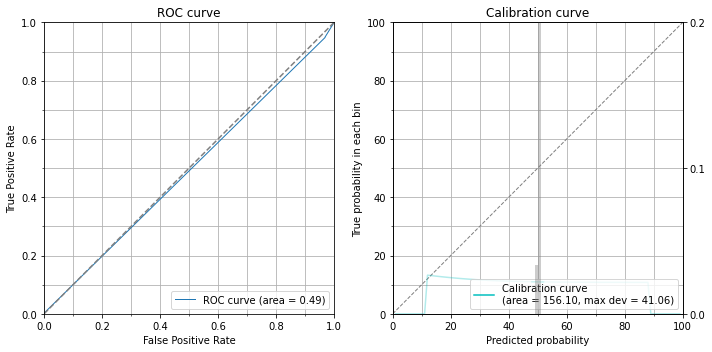

In [ ]:
model = xg.OpenplayXGModel()
model.model = search_logreg.best_estimator_
model._training_seasons = ["1718"]
model._fitted = True
print(model.validate(data_test, validation_seasons=["1718"]))
#model.save_model(f'{provider}_openplay_logreg_basic_fsf')

In [ ]:
index_cat = []

for col in CAT:
    print(f"Value counts for {col}:")
    value_counts = features[col].value_counts()
    
    # Filter out the counts that are zero or less than 2
    non_zero_counts = value_counts[value_counts > 1]
    
    # Print only the non-zero counts
    print(non_zero_counts)
    print(f"Number of distinct non-zero values for {col}: {len(non_zero_counts)}\n")
    
    # Append the column name once for each distinct non-zero value
    index_cat.extend([col] * len(non_zero_counts))

# Combine categorical and numeric indices
index_features = index_cat + NUM

# Print the total length of index_features
print(f"Total number of features: {len(index_features)}")


Value counts for type_id_a0:
shot    40461
Name: type_id_a0, dtype: int64
Number of distinct non-zero values for type_id_a0: 1

Value counts for type_id_a1:
pass                15720
dribble              9844
cross                5214
clearance            2309
corner_crossed       1910
interception         1646
take_on              1256
freekick_crossed      849
keeper_save           717
tackle                370
corner_short          201
throw_in              183
freekick_short        182
goalkick               41
shot                   18
Name: type_id_a1, dtype: int64
Number of distinct non-zero values for type_id_a1: 15

Value counts for type_id_a2:
pass                20228
dribble              4777
cross                3313
interception         2418
corner_crossed       1703
shot                 1503
take_on              1390
clearance            1372
foul                 1032
freekick_crossed      717
throw_in              563
keeper_save           371
freekick_short        311


In [ ]:
# Assuming `selected_indices` is a list or tuple of indices
feature_labels = []

# Iterate directly over `selected_indices`
for i in selected_indices:
    feature_labels.append(index_features[i])

# Print the selected feature labels
print(feature_labels)

['angle_zone_a0', 'angle_zone_a1']


In [20]:
#model = xg.XGModel.load_model(f'{provider}_openplay_logreg_basic_fsf')


(pd.DataFrame(
    data={'importance': model.model.named_steps['clf'].coef_[0]},index=feature_labels)
    .sort_values(by='importance').to_csv("feature_importance/feature_importance_forward_feature_selection_precision.csv"))